# sMRT: Sensor-based Multi-Resident Tracking

## Load Multi-resident Smart Home Dataset

In this example, I use TM004 as an example.
First, you will need to download the TM004 dataset from our website.
The following part of code helps to download the dataset and get it decompressed into `tm004_161219_9d` directory.

In [1]:
import os
import urllib.request
import zipfile

dataset_url = 'https://eecs.wsu.edu/~twang3/datasets/'
dataset_filename = 'tm004_161219_9d.zip'

def download_dataset(url, filename):
  """Download dataset file if not present.
  """
  local_filename = os.path.join(os.path.abspath(''), filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(
      url + filename, local_filename
    )

def read_dataset(filename):
  local_filename = os.path.join(os.path.abspath(''), filename)
  with zipfile.ZipFile(local_filename) as f:
    f.extractall(os.path.abspath(''))

download_dataset(dataset_url, dataset_filename)
read_dataset(dataset_filename)

With the dataset decompressed into local directory, we use [`pycasas`](https://gitlab.com/leavesw/pycasas) Python library to load the data from the disk, read the recorded sensor events, generate sensor sequences and sensor observations.
For the ease of replicating this experiment, checkpoints are added after each step completes.
Dataset, sensor sequences and sensor observations are all saved to disk as binary files using `pickle` library.

In [2]:
# Constructing dataset, sensor sequence and sensor observation from
# disk.

import pickle
from pycasas.data import CASASDataset

# Load Dataset
dataset = CASASDataset(directory='tm004_161219_9d')
dataset.load_events(show_progress=True)
dataset.save('tm004.pkl')
dataset.summary()

# Save sensor sequence
sequence = dataset.to_sensor_sequence()
fp = open('tm004_sequence.pkl', 'wb')
pickle.dump(sequence, fp, protocol=-1)
fp.close()

# Save sensor observation
observations = dataset.to_observation_track()
fp = open('tm004_observation.pkl', 'wb')
pickle.dump(observations, fp, protocol=-1)
fp.close()

Loading events from events.csv. Total size: 7.2 MiB
Progress: 100%%


 25% (24939 of 98506) |####              | Elapsed Time: 0:00:00 ETA:  00:00:00

Dataset: tm004_161219_9d
Location: tm004_161219_9d
	 Sensor Types enabled: ['Control4-BatteryPercent', 'Control4-BatteryVoltage', 'Control4-LightSensor', 'Control4-Motion', 'Control4-Radio', 'Control4-Radio_error', 'Control4-Temperature', 'Control4-Door', 'Zigbee-Channel', 'Zigbee-MacAddr', 'Zigbee-NetSecCounter', 'Zigbee-Structure', 'system']
	 98506 events loaded.
	 25 sensors presented in the dataset.


100% (98506 of 98506) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


The following helps you to load dataset from the checkpoint files.

In [3]:
# Load dataset, sensor sequence and sensor observation from
# checkpoint files.

import pickle
from pycasas.data import CASASDataset

# Load Dataset from pickle file
dataset = CASASDataset.load('tm004.pkl')

# Save sensor sequence
fp = open('tm004_sequence.pkl', 'rb')
sequence = pickle.load(fp)
fp.close()
print("Load sensor sequence from checkpoint.")

# Save sensor observation
fp = open('tm004_observation.pkl', 'rb')
observations = pickle.load(fp)
fp.close()
print("Load sensor observations from checkpoint.")

Dataset tm004_161219_9d is loaded from file successfully.

Load sensor sequence from checkpoint.
Load sensor observations from checkpoint.


Illustrate the sensor sequence and sensor observation.

In [4]:
print('Illustrate sensor sequences')
for i in range(4):
    print("# Time Step: %d" % i)
    print("[%s]: %d" % (sequence[1][i].strftime('%Y-%m-%d %H:%M:%S.%f'), sequence[0][i]))

Illustrate sensor sequences
# Time Step: 0
[2016-12-19 00:00:01.137305]: 3
# Time Step: 1
[2016-12-19 00:00:01.312043]: 24
# Time Step: 2
[2016-12-19 00:00:10.498126]: 24
# Time Step: 3
[2016-12-19 00:00:11.987679]: 23


In [5]:
print('Illustrate sensor observation')
for i in range(4):
    print("# Time Step: %d" % i)
    for s in observations[0][i]:
        obs = observations[0][i][s]
        print("  [%d]: Start %s; Stop %s; Resident %s" % (
            s, obs['start'].strftime('%Y-%m-%d %H:%M:%S.%f'), obs['stop'].strftime('%Y-%m-%d %H:%M:%S.%f'), obs['residents']
        ))

Illustrate sensor observation
# Time Step: 0
  [3]: Start 2016-12-19 00:00:01.137305; Stop 2016-12-19 00:00:02.260762; Resident ['R2']
# Time Step: 1
  [3]: Start 2016-12-19 00:00:01.137305; Stop 2016-12-19 00:00:02.260762; Resident ['R2']
  [24]: Start 2016-12-19 00:00:01.312043; Stop 2016-12-19 00:00:09.000194; Resident ['R2']
# Time Step: 2
  [24]: Start 2016-12-19 00:00:10.498126; Stop 2016-12-19 00:00:16.121593; Resident ['R2']
# Time Step: 3
  [23]: Start 2016-12-19 00:00:11.987679; Stop 2016-12-19 00:00:13.110944; Resident ['R2']
  [24]: Start 2016-12-19 00:00:10.498126; Stop 2016-12-19 00:00:16.121593; Resident ['R2']


Notice that there are special cases where the `stop` time tag of a sensor event is set to `None`. One probable cause is the unstability in the sensor network where a **deactive** message is not received at the gateway. However, it may also occur at the very end of the dataset when the **deactive** message of the sensor event happens after the sensor event record cuts off.

The following example shows that at the end of the TM004 Dataset, sensor (with index 12) is **ON** all the time till the end of the dataset, while the corresponding **OFF** message is not available in this part of the dataset.

In [6]:
# Make sure that the start and stop are filled properly with value of type `datetime.datetime`
n_obs = len(observations[0])
for k in range(n_obs):
    for s in observations[0][k]:
        event_details = observations[0][k][s]
        if event_details['start'] is None or event_details['stop'] is None:
            print("Warning: Step %d, Sensor %s [%d]" % (k, dataset.sensor_list[s]['name'], s))
            for label in event_details:
                print("  ", label, ": ", event_details[label])

   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-08:00
   stop :  None
   residents :  []
   start :  2016-12-27 22:41:36.445246-0

/home/stwg/CASAS/smrt/smrt/visualizer/casas/_association.py:312: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch([], color='c', label='Sensor Active Window')


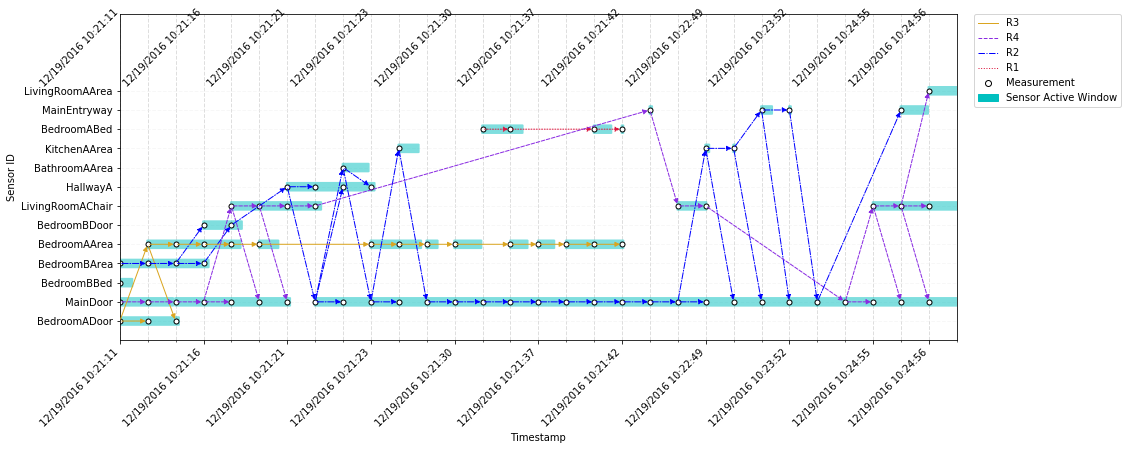

In [7]:
from smrt.visualizer.casas import plot_observation

_ = plot_observation(
    observations[0], observations[1], 2500,
    steps_before=5, steps_total=30,
    sensor_names=[sensor['name'] for sensor in dataset.sensor_list],
    track_colors={
        resident: dataset.get_resident_color(resident)
        for resident in dataset.resident_dict
    }
)

## Sensor Vectorization

The first step to sMRT for multi-resident tracking is translating individual sensors in the smart home into its vector representation in a virtual $m$-dimensional measurement space.
The sensor embeddings are computed similar to the word embeddings used in natural language processing applications. 

In [8]:
import os
import numpy as np
import random

skip_window = 7  # How many words to consider left and right.
num_skips = 14  # How many times to reuse an input to generate a label.
batch_size = 128 # Batch size
embedding_size = 3  # Dimension of the embedding vector.
num_sampled = 16  # Number of negative examples to sample.
num_epochs = 10 # Number of epochs to run NCE

In [9]:
def generate_train_pair(data, num_skips, skip_window):
  """Generating training dataset using skip gram models
  """
  num_windows = len(data) - 2 * skip_window
  size = num_windows * num_skips
  source = np.zeros(shape=(size,), dtype=np.int32)
  target = np.zeros(shape=(size,), dtype=np.int32)
  span = 2 * skip_window + 1
  for i in range(num_windows):
    context_sensors = [w for w in range(span) if w != skip_window]
    sensors_to_use = random.sample(context_sensors, num_skips)
    for j, context_sensor in enumerate(sensors_to_use):
      source[i * num_skips + j] = data[i + skip_window]
      target[i * num_skips + j] = data[i + context_sensor]
  return source, target

def get_training_pair(data, num_skips, skip_window):
  """Generating training pairs
  """
  # Form training filename
  training_dir = 'tm004_sv_training'
  embeddings_training_filename = os.path.join(
    training_dir, 'training.npz'
  )
  if os.path.exists(embeddings_training_filename):
    training_data = np.load(embeddings_training_filename)
    x = training_data['x']
    y = training_data['y']
  else:
    os.makedirs(training_dir, exist_ok=True)
    x, y = generate_train_pair(data, num_skips, skip_window)
    training_data = {
      'x': x, 'y': y
    }
    np.savez(embeddings_training_filename, **training_data)
  return x, y

x, y = get_training_pair(
  sequence[0], num_skips, skip_window
)

In [10]:
for i in range(10):
    print('%2d -> %2d  %s -> %s' % (x[i], y[i], dataset.sensor_list[x[i]]['name'], dataset.sensor_list[y[i]]['name']))

23 -> 24  OfficeAChair -> OfficeAArea
23 -> 24  OfficeAChair -> OfficeAArea
23 -> 24  OfficeAChair -> OfficeAArea
23 -> 24  OfficeAChair -> OfficeAArea
23 -> 14  OfficeAChair -> BedroomAArea
23 -> 24  OfficeAChair -> OfficeAArea
23 -> 24  OfficeAChair -> OfficeAArea
23 -> 24  OfficeAChair -> OfficeAArea
23 -> 23  OfficeAChair -> OfficeAChair
23 ->  3  OfficeAChair -> DiningRoomAArea


In [12]:
from datetime import datetime
import tensorflow as tf
import tensorflow.python.keras as keras
from smrt.learning.models.embedding import NCEModel
from smrt.utils import normalize_embeddings

vocab_size = len(dataset.sensor_list)
model = NCEModel(
  vocab_size=vocab_size,
  embeddings_size=embedding_size,
  nce_num_sampled=num_sampled
)
optimizer = keras.optimizers.RMSprop(
  lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0
)

def empty_loss(y_true, y_pred):
  return tf.constant(0.)

model.compile(
  optimizer=optimizer,
  loss=empty_loss
)

# Prepare tensorboard callback
logdir = os.path.join('tm004_sv_training', 'log', datetime.now().strftime("tm004_vec_%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, profile_batch=0)
os.makedirs(logdir, exist_ok=True)

model.fit(
  x=[x.reshape([-1, 1]), y.reshape([-1, 1])],
  y=y,
  epochs=num_epochs,
  batch_size=64,
  callbacks=[tensorboard_callback]
)

sensor_x = np.arange(vocab_size)
embeddings = model.predict((
  sensor_x.reshape([-1, 1]), sensor_x.reshape([-1, 1])
))
normalized_embeddings = normalize_embeddings(embeddings)
print(normalized_embeddings)

np.savez('tm004_embeddings.npz', normalized_embeddings)

/home/stwg/.conda/envs/ml2019/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 689346 samples
Epoch 1/10
689346/689346 [==============================] - 17s 25us/sample - loss: 3.4533
Epoch 2/10
689346/689346 [==============================] - 17s 25us/sample - loss: 2.6919
Epoch 3/10
689346/689346 [==============================] - 17s 24us/sample - loss: 2.6766
Epoch 4/10
689346/689346 [==============================] - 17s 25us/sample - loss: 2.6687
Epoch 5/10
689346/689346 [==============================] - 17s 25us/sample - loss: 2.6649
Epoch 6/10
689346/689346 [==============================] - 17s 25us/sample - loss: 2.6580
Epoch 7/10
689346/689346 [==============================] - 17s 25us/sample - loss: 2.6525
Epoch 8/10
689346/689346 [==============================] - 17s 24us/sample - loss: 2.6439
Epoch 9/10
689346/689346 [==============================] - 17s 24us/sample - loss: 2.6405
Epoch 10/10
689346/689346 [==============================] - 17s 24us/sample - loss: 2.6361
[[ 0.83681345 -0.3949965   0.37910557]
 [ 0.5084753   0.59097403 

In [13]:
import numpy as np

# Load normalized embedding from dataset
normalized_embeddings = np.load('tm004_embeddings.npz', allow_pickle=True)['arr_0']
print(normalized_embeddings)

[[ 0.83681345 -0.3949965   0.37910557]
 [ 0.5084753   0.59097403 -0.6262608 ]
 [ 0.6271109  -0.6823814   0.37561625]
 [ 0.10787528  0.6243493  -0.7736607 ]
 [ 0.7155143   0.6687521  -0.20201463]
 [-0.17613009  0.46521568 -0.86749786]
 [ 0.42292964 -0.8670359   0.2633994 ]
 [-0.18696797  0.38708282 -0.9028897 ]
 [-0.24570695  0.39147756 -0.886777  ]
 [ 0.24171709  0.68608814 -0.6861894 ]
 [ 0.9533213  -0.29684123  0.05535247]
 [-0.16669595 -0.9801505   0.1073191 ]
 [ 0.8068769   0.5853079  -0.07977689]
 [ 0.14303744 -0.96951354  0.1989568 ]
 [ 0.69155604 -0.6012228   0.40035167]
 [-0.30489644 -0.9519163   0.02989228]
 [ 0.20730741  0.62693447 -0.7509838 ]
 [ 0.74445635  0.6460042  -0.16871087]
 [ 0.05692211  0.5407556  -0.8392515 ]
 [-0.3827182  -0.92374545 -0.01487097]
 [ 0.32510588 -0.92263955  0.20746669]
 [ 0.74479175  0.6472559  -0.16231166]
 [-0.33381686 -0.9424717   0.01770571]
 [-0.61669105 -0.6757439  -0.40380985]
 [-0.6073194  -0.6547563  -0.44995254]]


## Resident Tracking

In [14]:
def translate_observations(observations, embeddings):
  """Translate sensor observations into sensor embeddings

  Args:
    observations: Sensor observations
    embeddings: Sensor embeddings of shape `[num_sensors, n_visible]`

  Returns:
    List of sensor observations, each is in the form of shape
    `[num_obs, n_visible]` and can be used directly with multi-target tracker.
  """
  vec_observations = []
  sensor_observations = []
  for observation in observations[0]:
    sensors = list(observation.keys())
    obs_matrix = np.copy(embeddings[sensors, :])
    vec_observations.append(obs_matrix)
    sensor_observations.append(sensors)
  return vec_observations, sensor_observations

# Translate to vector array
vec_observations, sensor_observations = translate_observations(
  observations, normalized_embeddings
)

In [15]:
for i in range(4):
    print("-- Step %d" % i)
    vec_obs = vec_observations[i]
    orig_obs = observations[0][i]
    print("  Active Sensors: ", list(orig_obs.keys()))
    print("  Vector Representation")
    for k in range(vec_obs.shape[0]):
        print("    ", vec_obs[k, :])

-- Step 0
  Active Sensors:  [3]
  Vector Representation
     [ 0.10787528  0.6243493  -0.7736607 ]
-- Step 1
  Active Sensors:  [3, 24]
  Vector Representation
     [ 0.10787528  0.6243493  -0.7736607 ]
     [-0.6073194  -0.6547563  -0.44995254]
-- Step 2
  Active Sensors:  [24]
  Vector Representation
     [-0.6073194  -0.6547563  -0.44995254]
-- Step 3
  Active Sensors:  [23, 24]
  Vector Representation
     [-0.61669105 -0.6757439  -0.40380985]
     [-0.6073194  -0.6547563  -0.44995254]


In [17]:
from tensorflow.python.keras.utils.generic_utils import Progbar
from smrt.synthetic import CvMTGM_ID_Model
from smrt.utils.gmhdf import GMHdf5

embeddings = normalized_embeddings
Jmax = 100 # Maximum 100 Gaussian Components

def smrt_model(embeddings,
               b_weight,
               b_stddev,
               m_stddev,
               v_stddev,
               p_d,
               p_s,
               clutter_lam):
  """Composing SMRT Multi-resident Tracking Models

  Provided with the sensor embeddings, the dimension of the space, and other
  hyperparameters including birth weights, standard deviation of the dynamic
  model, measurement model, the birth location, the probability of target
  detection and target persistence.

  Args:
    embeddings: Sensor embeddings of shpae `[num_sensors, n_visible]`
    b_weight: Weight of each Gaussian component in the birth PHD
    b_stddev: The standard deviation of birth PHD
    m_stddev: The standard deviation of the linear Gaussian dynamic model
    v_stddev: The standard deviation of the linear Gaussian measurement model
    p_d: The target detection probability
    p_s: The target persistence probability
    clutter_lam: Parameter of the Poisson clutter process

  Returns:
    A constant velocity tracking model.
  """
  n_visible = embeddings.shape[1]
  n_sensors = embeddings.shape[0]
  birth_weights = np.ones((n_sensors,), dtype=np.float) * b_weight
  birth_means = np.block([
    embeddings, np.zeros_like(embeddings)
  ])
  birth_covs = np.broadcast_to(
    np.identity(2 * n_visible), (n_sensors, 2 * n_visible, 2 * n_visible)
  ) * (b_stddev * b_stddev)
  return CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_stddev,
    m_stddev=m_stddev,
    birth=(birth_weights, birth_means, birth_covs),
    p_d=p_d,
    p_s=p_s,
    clutter_lam=clutter_lam,
    clutter_c=1/(2 ** n_visible)
  )

model = smrt_model(
  embeddings=embeddings,
  b_weight=0.5/embeddings.shape[0],
  b_stddev=0.1,
  m_stddev=0.1,
  v_stddev=0.1,
  p_d=0.9,
  p_s=0.9,
  clutter_lam=1
)

# Initial weights, means and covariances
gm_weights = np.zeros((0,))
gm_means = np.zeros((0, model.ndims))
gm_covs = np.zeros((0, model.ndims, model.ndims))

# Records
gmphd_record = GMHdf5(
  'gmphd_records.hdf5', mode='w', length=8000,
  ndims=model.ndims, Jmax=Jmax, chunk_size=1000
)
predicted_association = []

# As the filter will run for a while, show progress bar
progbar = Progbar(
  #target=len(vec_observations),
  target=8000,
  verbose=1,
  stateful_metrics=['targets', 'residents'],
  unit_name='step'
)

#for k in range(len(vec_observations)):
for k in range(8000):
  # Call the filter process
  gm_weights, gm_means, gm_covs = model.call(
    (gm_weights, gm_means, gm_covs, vec_observations[k])
  )
  # Truncate
  gm_weights, gm_means, gm_covs = model.gm_truncate(
    gm_weights, gm_means, gm_covs, Jmax
  )
  # Clustering
  gm_weights, gm_means, gm_covs = model.gm_id_cluster(
    gm_weights, gm_means, gm_covs
  )
  # Save PHD Gaussian mixtures
  gmphd_record.save_single_gm(
    k,
    np.copy(gm_weights),
    np.copy(gm_means),
    np.copy(gm_covs)
  )
  gmphd_record.flush()
  # Resident Association
  ota = model.observation_association(
    gm_weights, gm_means, gm_covs, vec_observations[k]
  )
  predicted_association.append({
    'resident': ota,
    'sensor': sensor_observations[k]
  })
  # Get number of residents
  residents = []
  for sensor in sensor_observations[k]:
    for r in observations[0][k][sensor]['residents']:
      if r not in residents:
        residents.append(r)
  progbar.update(k+1, [
    ('targets', np.sum(gm_weights)),
    ('residents', len(residents))
  ])

OSError: Unable to create file (unable to truncate a file which is already open)

In [ ]:
dataset.sensor_indices_dict

In [ ]:
import pickle

# Save association
fp = open('prediction_association.pkl', 'wb')
pickle.dump(predicted_association, fp, protocol=-1)
fp.close()

In [ ]:
import pickle

# Load association
fp = open('prediction_association.pkl', 'rb')
predicted_association = pickle.load(fp)
fp.close()

In [ ]:
print(predicted_association)

In [ ]:
from smrt.metrics import mrt_metrics

In [ ]:
events_by_track = mrt_metrics.group_events_by_track(
  observations[0], predicted_association
)
track_length = mrt_metrics.event_length_by_track(events_by_track)
track_resident_map = mrt_metrics.associate_track_with_resident(events_by_track)
event_list = mrt_metrics.group_prediction_by_events(observations[0], predicted_association)

print(mrt_metrics.mrt_classification_report(observations[0], predicted_association))

In [ ]:
for i in range(10):
    print(mrt_metrics.mrt_association_accuracy(observations[0], predicted_association, min_length=i))

In [ ]:
for i in range(10):
    print(mrt_metrics.mrt_hamming_loss(observations[0], predicted_association, min_length=i))

In [ ]:
fp = open('tm004_smrt_tc_event_list.pkl', 'rb')
event_list = pickle.load(fp)
fp.close()

In [ ]:
mrt_metrics.mrta(event_list, min_length=7, max_undetected_period=50)

In [ ]:
len(observations[0])